In [6]:
import numpy as np
from scipy.sparse import lil_matrix
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm

# 1. Create the Gaussian Kernel (9x9)
kernel_size = 9
sigma = 1.0  # Standard deviation for the Gaussian kernel
kernel = np.outer(
    gaussian_filter(np.ones(kernel_size), sigma),
    gaussian_filter(np.ones(kernel_size), sigma),
)
kernel /= kernel.sum()  # Normalize the kernel

# 2. Vectorize the Image (Assuming you have a 500x600 image as a NumPy array)
image = cv2.imread("image.jpg", cv2.IMREAD_GRAYSCALE)  # Replace with your actual image
height, width = image.shape
x = cv2.imread("image.jpg", cv2.IMREAD_GRAYSCALE)

# 3. Construct the Convolution Matrix (A) as a sparse matrix
A = lil_matrix((height * width, height * width))  # Create a sparse matrix in LIL format

# Apply the Gaussian kernel to the image and construct the matrix A
for i in tqdm(range(height)):
    for j in range(width):
        # Define the region of the image that the kernel will apply to
        row_start = max(i - kernel_size // 2, 0)
        row_end = min(i + kernel_size // 2 + 1, height)
        col_start = max(j - kernel_size // 2, 0)
        col_end = min(j + kernel_size // 2 + 1, width)

        # Get the corresponding values from the kernel for the region
        region = image[row_start:row_end, col_start:col_end]
        kernel_region = kernel[
            kernel_size // 2 - (i - row_start) : kernel_size // 2 + (row_end - i),
            kernel_size // 2 - (j - col_start) : kernel_size // 2 + (col_end - j),
        ]

        # Add the kernel weights to the corresponding entries in matrix A
        for di in range(row_start, row_end):
            for dj in range(col_start, col_end):
                A[i * width + j, di * width + dj] = kernel_region[
                    di - row_start, dj - col_start
                ]

# 4. Perform the Matrix Multiplication A * x to apply the convolution
y = A.dot(x)

# Reshape the result back to the image shape
y_image = y.reshape((height, width))

# Display the original and the blurred image
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image, cmap="gray")
plt.title("Original Image")
plt.subplot(1, 2, 2)
plt.imshow(y_image, cmap="gray")
plt.title("Blurred Image (Convolution)")
plt.show()

100%|██████████| 558/558 [00:44<00:00, 12.65it/s]


ValueError: dimension mismatch

In [30]:

# From https://hackmd.io/@machine-learning/blog-post-cnnumpy-fast

def kernel_init(kernel_shape, init_type="he"):

    if init_type == "he":
        std = np.sqrt(2.0 / np.sqrt(kernel_shape.shape[1] * kernel_shape.shape[2] * kernel_shape.shape[3])) 
        weight = np.random.normal(0, std, kernel_shape.shape)
        bias = np.random.normal(0, std, (1))

    return weight, bias

def get_indices(X_shape, HF, WF, stride, pad):
    """
        Returns index matrices in order to transform our input image into a matrix.

        Parameters:
        -X_shape: Input image shape.
        -HF: filter height.
        -WF: filter width.
        -stride: stride value.
        -pad: padding value.

        Returns:
        -i: matrix of index i.
        -j: matrix of index j.
        -d: matrix of index d. 
            (Use to mark delimitation for each channel
            during multi-dimensional arrays indexing).
    """
    # get input size
    m, n_C, n_H, n_W = X_shape

    # get output size
    out_h = int((n_H + 2 * pad - HF) / stride) + 1
    out_w = int((n_W + 2 * pad - WF) / stride) + 1
  
    # ----Compute matrix of index i----

    # Level 1 vector.
    level1 = np.repeat(np.arange(HF), WF)
    # Duplicate for the other channels.
    level1 = np.tile(level1, n_C)
    # Create a vector with an increase by 1 at each level.
    everyLevels = stride * np.repeat(np.arange(out_h), out_w)
    # Create matrix of index i at every levels for each channel.
    i = level1.reshape(-1, 1) + everyLevels.reshape(1, -1)

    # ----Compute matrix of index j----
    
    # Slide 1 vector.
    slide1 = np.tile(np.arange(WF), HF)
    # Duplicate for the other channels.
    slide1 = np.tile(slide1, n_C)
    # Create a vector with an increase by 1 at each slide.
    everySlides = stride * np.tile(np.arange(out_w), out_h)
    # Create matrix of index j at every slides for each channel.
    j = slide1.reshape(-1, 1) + everySlides.reshape(1, -1)

    # ----Compute matrix of index d----

    # This is to mark delimitation for each channel
    # during multi-dimensional arrays indexing.
    d = np.repeat(np.arange(n_C), HF * WF).reshape(-1, 1)

    return i, j, d

def im2col(X, HF, WF, stride, pad):
    """
        Transforms our input image into a matrix.

        Parameters:
        - X: input image.
        - HF: filter height.
        - WF: filter width.
        - stride: stride value.
        - pad: padding value.

        Returns:
        -cols: output matrix.
    """
    # Padding
    X_padded = np.pad(X, ((0,0), (0,0), (pad, pad), (pad, pad)), mode='constant')
    i, j, d = get_indices(X.shape, HF, WF, stride, pad)
    # Multi-dimensional arrays indexing.
    cols = X_padded[:, d, i, j]
    cols = np.concatenate(cols, axis=-1)
    return cols

def col2im(dX_col, X_shape, HF, WF, stride, pad):
    """
        Transform our matrix back to the input image.

        Parameters:
        - dX_col: matrix with error.
        - X_shape: input image shape.
        - HF: filter height.
        - WF: filter width.
        - stride: stride value.
        - pad: padding value.

        Returns:
        -x_padded: input image with error.
    """
    # Get input size
    N, D, H, W = X_shape
    # Add padding if needed.
    H_padded, W_padded = H + 2 * pad, W + 2 * pad
    X_padded = np.zeros((N, D, H_padded, W_padded))
    
    # Index matrices, necessary to transform our input image into a matrix. 
    i, j, d = get_indices(X_shape, HF, WF, stride, pad)
    # Retrieve batch dimension by spliting dX_col N times: (X, Y) => (N, X, Y)
    dX_col_reshaped = np.array(np.hsplit(dX_col, N))
    # Reshape our matrix back to image.
    # slice(None) is used to produce the [::] effect which means "for every elements".

    np.add.at(X_padded, (slice(None), d, i, j), dX_col_reshaped)
    # Remove padding from new image if needed.
    #print("col2im", X_padded.shape, pad)
    if pad == 0:
        return X_padded
    elif type(pad) is int:
        return X_padded[:, :, pad:-pad, pad:-pad]


def forward(X, kernels, b, pad, stride):
    """
        Performs a forward convolution.

        Parameters:
        - X : Last conv layer of shape (m, n_C_prev, n_H_prev, n_W_prev).
        Returns:
        - out: previous layer convolved.
    """
    m, n_C_prev, n_H_prev, n_W_prev = X.shape
    n_F, f = kernels.shape[0], kernels.shape[1]
    n_F = 1
    f = kernels.shape[0]


    n_C = n_F
    n_H = int((n_H_prev + 2 * pad - f)/ stride) + 1
    n_W = int((n_W_prev + 2 * pad - f)/ stride) + 1

    X_col = im2col(X, f, f, stride, pad)
    w_col = kernels.reshape((n_F, -1))
    b_col = 0
    # Perform matrix multiplication.
    print(w_col.shape)
    print(X_col.shape)
    out = w_col @ X_col + b_col
    # Reshape back matrix to image.
    out = np.array(np.hsplit(out, m)).reshape((m, n_C, n_H, n_W))
    return out

In [31]:
import numpy as np
from scipy.sparse import lil_matrix
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm

filter_size = 5
low_pass_filter = np.ones((filter_size, filter_size))/9

image = cv2.imread("image.jpg", cv2.IMREAD_GRAYSCALE)  # Replace with your actual image
height, width = image.shape
x = cv2.imread("image.jpg", cv2.IMREAD_GRAYSCALE)
x = np.reshape(x, (1, 1, x.shape[0], -1))

deneme = forward(x, low_pass_filter, 0, 1, 1)


(1, 9)
(9, 282348)


In [34]:
deneme.shape

(1, 1, 558, 506)

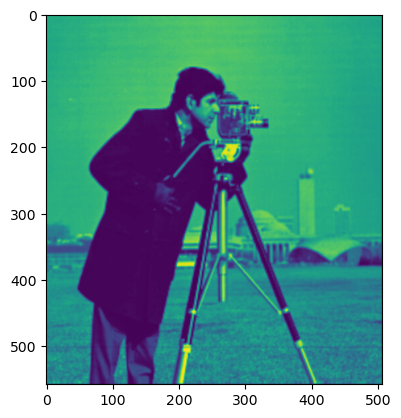

In [36]:
plt.imshow(deneme[0, 0, :, :])

In [17]:
image.shape

(558, 506)

In [18]:
asd = np.reshape(image, (1, 1, image.shape[0], -1))